## Table of Contents
- [1. Web scraping & data cleaning](#1)
- [2. Topic models](#2)
    - [2.1. LDA](#2.1)
    - [2.2. BTM](#2.2)
    - [2.3. NMF](#2.3)
    - [2.4. CorEx](#2.4)

### 1. Web scraping & data cleaning <a class="anchor" id="1"></a>

In [1]:
from bs4 import BeautifulSoup
import requests
from nltk.tokenize import word_tokenize
import re

#get list of character & season names so that they can be removed from text

#store names of characters & seasons here
char_tokens = []

#webpages for characters may be found on 2 pages
char_urls = ["https://americanhorrorstory.fandom.com/wiki/Category:Characters",
             "https://americanhorrorstory.fandom.com/wiki/Category:Characters?from=Mars%2C+Elsa%0AElsa+Mars"]

for url in char_urls:
    char_page = requests.get(url)
    char_soup = BeautifulSoup(char_page.content, "html.parser")

    char_list = char_soup.find("div", class_="category-page__members").text.replace("<br/>", "")
    char_list = re.sub(r'[^\w\s]', '', char_list).strip()

    tokens = word_tokenize(char_list.lower())
                
    for char in tokens:
        #do not append character names where len(char) == 1
        if len(char) > 1:
            char_tokens.append(char)
            

In [2]:
#number of episodes per season
seasons_episodes = [[1, 12], [2, 13], [3, 13], [4, 13], [5, 12], [6, 10], [7, 11], [8, 10]]
base_url = "https://www.springfieldspringfield.co.uk/view_episode_scripts.php?tv-show=american-horror-story&episode="

#nltk stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

#get extended list of stopwords (nltk's list is not so comprehensive)
additional_stopwords = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
additional_stopwords = additional_stopwords.decode().splitlines()
additional_stopwords = [re.sub(r'[^\w\s]', '', word) for word in additional_stopwords]
stop_words.extend(additional_stopwords)

#extra stopwords after conducting FreqDist (abbreviations of character names, exclamations, etc)
stop_words.extend(["english", "sdh", "retail", "subrip", "jeem", "baby", "gon", "hey",
          "yeah", "uh", "heh", "ha", "wan", "hmm", "huh",
          "damn", "â", "goddamn", "fuck", "shit", "fucking", "_",
          "viv", "judy", "briarcliff", "ozzie", "ivy", "delia", "marjorie"])

#add character & season names to stop word list
stop_words.extend(char_tokens)

#get set of english words so that we can filter out non-english words
from nltk.corpus import words
english_words = set(words.words())

#in preparation for lemmatization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

#list of documents
data_words = []

for season in seasons_episodes:
    
    season_no = season[0]
    episodes = season[1]
    
    for episode in range(1, episodes + 1):
        
        #each episode will be a document
        episode_script = []
        
        if len(str(episode)) == 1: #prefix episode number with 0 if episode is single digit e.g. e01
            url = base_url + 's' + '0' + str(season_no) + 'e' + '0' + str(episode)
        else:
            url = base_url + 's' + '0' + str(season_no) +  'e' + str(episode)
        
        page = requests.get(url)
        soup = BeautifulSoup(page.content, "html.parser")
        
        doc = soup.find("div", class_="scrolling-script-container").text.replace("<br/>", "")
        
        #remove reactions/acting directions e.g. [GASPS], (COUGHS), etc.
        removed_reactions = re.sub(r'\[[^\]]*\]', '', doc)
        removed_reactions = re.sub(r'\([^)]*\)', '', removed_reactions)
        
        #remove numbers, punctuation
        removed_digits = re.sub(r'\d', '', removed_reactions)
        removed_punct = re.sub(r'[^\w\s]', '', removed_digits).strip()
        
        #tokenize
        tokens = word_tokenize(removed_punct.lower())

        #remove stopwords, single characters and make sure the word is english
        for t in tokens:
            if t not in stop_words and len(t) > 1 and t in english_words:
                
                #lemmatize tokens
                lemmatized_token = lemmatizer.lemmatize(t)
                episode_script.append(lemmatized_token)
        
        #append episode to list of documents
        data_words.append(episode_script)
        
    print ('season', season_no, 'done') #helps track progress

season 1 done
season 2 done
season 3 done
season 4 done
season 5 done
season 6 done
season 7 done
season 8 done


In [3]:
#write dataset to file
import csv
with open('dataset.csv', 'w') as f: 
    write = csv.writer(f) 
    write.writerows(data_words)

In [4]:
#check mean document length
import numpy as np
print('Number of documents: ', len(data_words))
print('Mean document length: ', np.sum(len(ep) for ep in data_words) / len(data_words))

Number of documents:  94
Mean document length:  754.8191489361702


/var/folders/4w/gm8h7rpj357763xbhgq_jznm0000gn/T/ipykernel_32929/797375512.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  print('Mean document length: ', np.sum(len(ep) for ep in data_words) / len(data_words))


### 2. Topic models <a class="anchor" id="2"></a>

### 2.1. LDA <a class="anchor" id="2.1"></a>

In [5]:
#LDA preprocessing
import gensim.corpora as corpora
from pprint import pprint

#create dictionary
id2word = corpora.Dictionary(data_words)

#term document frequency
texts = data_words

#create corpus
corpus = [id2word.doc2bow(text) for text in texts]

#view
print(corpus[:1][0][:30])


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 10), (6, 1), (7, 2), (8, 5), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 2), (20, 4), (21, 1), (22, 2), (23, 1), (24, 3), (25, 1), (26, 1), (27, 4), (28, 1), (29, 1)]


In [6]:
from gensim.models import CoherenceModel
from gensim import models

lda_perplexity_scores = []
lda_coherence_scores = []

for i in range(1, 51):
    num_topics = i
    
    #initialise and run LDA model
    lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word = id2word, num_topics=num_topics, random_state=100,
                                         update_every=1, chunksize=20, passes=10, alpha='auto', per_word_topics=True)

    #calculating model perplexity
    perplexity = lda_model.log_perplexity(corpus)
    lda_perplexity_scores.append(perplexity)
    
    #calculating model coherence
    cm = CoherenceModel(model=lda_model, dictionary=id2word, texts=texts, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    lda_coherence_scores.append(coherence)


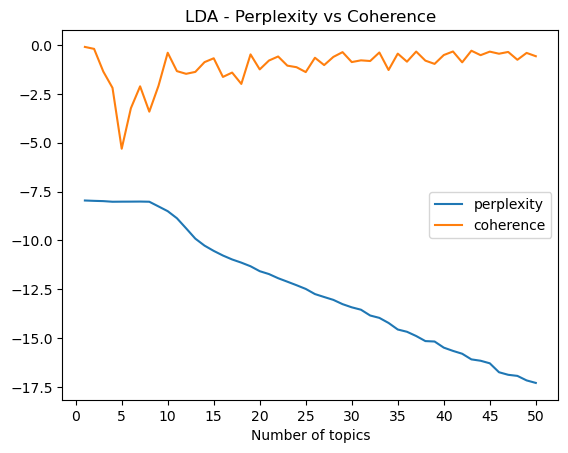

In [7]:
#plot perplexity against coherence for x topics
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(range(1, 51), lda_perplexity_scores, label = "perplexity")
plt.plot(range(1, 51), lda_coherence_scores, label = "coherence")
plt.xlabel('Number of topics')
ax.set_xticks(np.arange(0, 51, step=5))
plt.legend(loc='right')
plt.title('LDA - Perplexity vs Coherence')
plt.show()
#plt.savefig("plots/lda_pvsc.png")


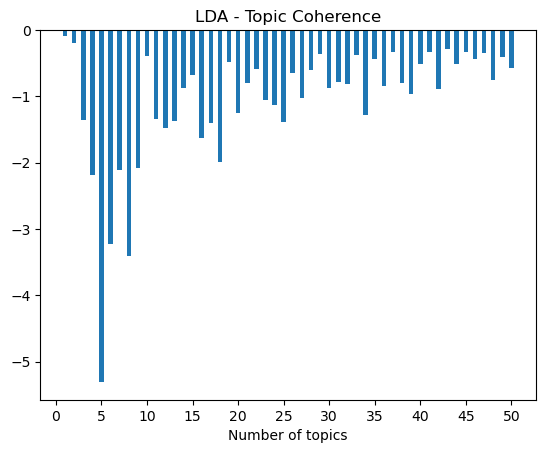

In [8]:
#looking at just topic coherence
fig, ax = plt.subplots()
plt.bar(range(1, 51), lda_coherence_scores, width=0.5)
plt.xlabel('Number of topics')
ax.set_xticks(np.arange(0, 51, step=5))
plt.title('LDA - Topic Coherence')
plt.show()
#plt.savefig("plots/lda_c.png")


In [14]:
#although there does not seem to be an optimal number of topics, we print topic words where coherence is closest to 0 (k=10)
lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word = id2word, num_topics=10, random_state=100,
                                     update_every=1, chunksize=20, passes=10, alpha='auto', per_word_topics=True)
pprint(lda_model.print_topics())


[(0,
  '0.000*"good" + 0.000*"time" + 0.000*"god" + 0.000*"thought" + 0.000*"leave" '
  '+ 0.000*"told" + 0.000*"woman" + 0.000*"girl" + 0.000*"family" + '
  '0.000*"love"'),
 (1,
  '0.000*"time" + 0.000*"good" + 0.000*"god" + 0.000*"love" + 0.000*"night" + '
  '0.000*"thought" + 0.000*"people" + 0.000*"doctor" + 0.000*"work" + '
  '0.000*"talk"'),
 (2,
  '0.002*"snoopy" + 0.002*"fluffer" + 0.002*"dragon" + 0.001*"carving" + '
  '0.001*"granny" + 0.001*"bobbing" + 0.001*"pat" + 0.001*"decorate" + '
  '0.001*"elle" + 0.001*"viol"'),
 (3,
  '0.002*"sen" + 0.002*"tout" + 0.001*"compliment" + 0.001*"godliness" + '
  '0.001*"salve" + 0.001*"inversion" + 0.001*"decadent" + 0.001*"harmless" + '
  '0.000*"shave" + 0.000*"oversight"'),
 (4,
  '0.000*"god" + 0.000*"good" + 0.000*"time" + 0.000*"doctor" + 0.000*"love" + '
  '0.000*"thing" + 0.000*"place" + 0.000*"wife" + 0.000*"work" + 0.000*"girl"'),
 (5,
  '0.000*"god" + 0.000*"time" + 0.000*"good" + 0.000*"girl" + 0.000*"love" + '
  '0.000*"ni

In [10]:
#although there does not seem to be an optimal number of topics, we print topic words where coherence = minimum (k=5)
lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word = id2word, num_topics=5, random_state=100,
                                     update_every=1, chunksize=20, passes=10, alpha='auto', per_word_topics=True)
pprint(lda_model.print_topics())


[(0,
  '0.003*"storm" + 0.001*"sprite" + 0.001*"therapy" + 0.001*"butler" + '
  '0.001*"stepmother" + 0.001*"surgical" + 0.001*"ant" + 0.001*"collateral" + '
  '0.001*"harvester" + 0.001*"searing"'),
 (1,
  '0.012*"time" + 0.008*"people" + 0.007*"life" + 0.006*"supreme" + '
  '0.006*"kill" + 0.005*"place" + 0.005*"good" + 0.005*"power" + 0.005*"witch" '
  '+ 0.004*"die"'),
 (2,
  '0.013*"time" + 0.011*"god" + 0.008*"love" + 0.008*"good" + 0.007*"people" + '
  '0.006*"thing" + 0.006*"feel" + 0.006*"thought" + 0.006*"night" + '
  '0.005*"life"'),
 (3,
  '0.008*"people" + 0.008*"men" + 0.007*"turd" + 0.007*"hail" + 0.005*"hate" + '
  '0.005*"scum" + 0.004*"whoa" + 0.004*"ruler" + 0.004*"pussy" + '
  '0.004*"pastor"'),
 (4,
  '0.005*"narrator" + 0.004*"cardinal" + 0.003*"banana" + 0.003*"interview" + '
  '0.002*"bo" + 0.002*"freedom" + 0.002*"verdict" + 0.002*"weeping" + '
  '0.002*"wail" + 0.002*"ye"')]


### 2.2. BTM <a class="anchor" id="2.2"></a>

In [11]:
#BTM preprocessing
import bitermplus as btm
import numpy as np
import pandas as pd

#document list for BTM
btm_episodes = []

#reformat data to work for the btm library
for episode in data_words:
    episode_string = ' '.join(episode)
    btm_episodes.append(episode_string)

#obtain terms frequency in a sparse matrix and corpus vocabulary
X, vocabulary, vocab_dict = btm.get_words_freqs(btm_episodes)
tf = np.array(X.sum(axis=0)).ravel()

#vectorize documents
docs_vec = btm.get_vectorized_docs(btm_episodes, vocabulary)
docs_lens = list(map(len, docs_vec))

#generate biterms
biterms = btm.get_biterms(docs_vec)


In [13]:
btm_perplexity_scores = []
btm_coherence_scores = []

for i in range(1, 51):
    num_topics = i

    #initialise and run BTM model
    model = btm.BTM(X, vocabulary, seed=12321, T=num_topics, M=20, alpha=50/8, beta=0.01)
    model.fit(biterms, iterations=20, verbose=False)
    p_zd = model.transform(docs_vec)

    #calculating model perplexity
    perplexity = btm.perplexity(model.matrix_topics_words_, p_zd, X, num_topics)
    btm_perplexity_scores.append(perplexity)
    
    #calculating model coherence
    coherence = btm.coherence(model.matrix_topics_words_, X, M=20)
    #output is an array of scores - take the average
    avg_coherence = np.mean(coherence)
    btm_coherence_scores.append(avg_coherence)
    

100%|██████████████████████████████████████████| 94/94 [00:00<00:00, 232.10it/s]


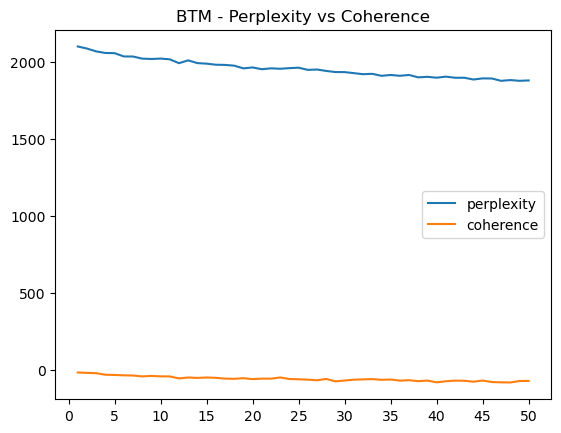

In [15]:
#plot perplexity against coherence for x topics

fig, ax = plt.subplots()
plt.plot(range(1, 51), btm_perplexity_scores, label = "perplexity")
plt.plot(range(1, 51), btm_coherence_scores, label = "coherence")
ax.set_xticks(np.arange(0, 51, step=5))
#ax.set_yticks(np.arange(-10, 0, step=2))
plt.legend(loc='right')
plt.title('BTM - Perplexity vs Coherence')
plt.show()
#plt.savefig("plots/btm_pvsc.png")


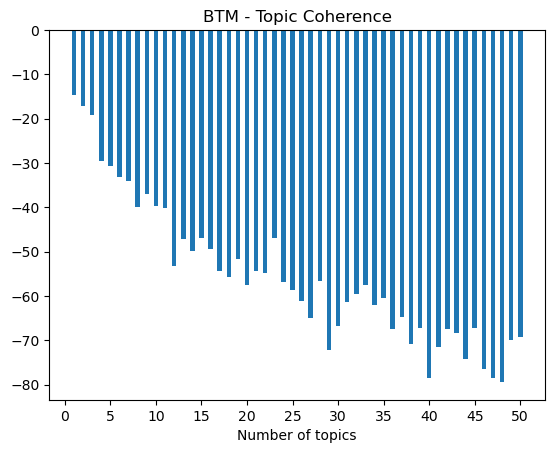

In [16]:
#looking at just topic coherence
fig, ax = plt.subplots()
plt.bar(range(1, 51), btm_coherence_scores, width=0.5)
plt.xlabel('Number of topics')
ax.set_xticks(np.arange(0, 51, step=5))
plt.title('BTM - Topic Coherence')
plt.show()
#plt.savefig("plots/btm_c.png")


In [17]:
#view topic words where T = 5
model = btm.BTM(X, vocabulary, seed=12321, T=5, M=20, alpha=50/8, beta=0.01)
model.fit(biterms, iterations=10, verbose=False)
p_zd = model.transform(docs_vec)


100%|█████████████████████████████████████████| 94/94 [00:00<00:00, 1036.02it/s]


In [18]:
#visualising results
import tmplot as tmp
#tmp.report(model=model, docs=btm_episodes, width=250)

#plot topics as a scatter plot
topics_coords = tmp.prepare_coords(model)
tmp.plot_scatter_topics(topics_coords, size_col='size', label_col='label')


alt.LayerChart(...)

In [27]:
#get topic words for topics = n
n=5
phi = tmp.get_phi(model)
phi.head()

#view topic words and probabilities
terms_probs = tmp.calc_terms_probs_ratio(phi, topic=0, lambda_=1) #set lambda to 1 for topic-specific probabilities
tmp.plot_terms(terms_probs)


alt.Chart(...)

### 2.3. NMF <a class="anchor" id="2.3"></a>

In [28]:
#NMF preprocessing

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import pandas as pd

#pass this tokenizer as our texts are already tokenized
def identity_tokenizer(text):
    return text

# Store TF-IDF Vectorizer of top 20000 words
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False)  

# Fit and Transform text to a TF-IDF Doc-Term Matrix
data_tfidf = tfidf.fit_transform(data_words)

# Create data-frame of Doc-Term Matrix with nouns as column names
data_dtm = pd.DataFrame(data_tfidf.toarray(), columns=tfidf.get_feature_names())

# Visually inspect Document Term Matrix
data_dtm.head()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


aa  abacus  abandon  abandoned  abandonment  abdication  abdominal  \
0  0.0     0.0      0.0        0.0          0.0         0.0   0.000000   
1  0.0     0.0      0.0        0.0          0.0         0.0   0.000000   
2  0.0     0.0      0.0        0.0          0.0         0.0   0.000000   
3  0.0     0.0      0.0        0.0          0.0         0.0   0.049665   
4  0.0     0.0      0.0        0.0          0.0         0.0   0.000000   

   abduction  abhorrent  abide  ...  zenith  zinc  zing  zip  zipper  zodiac  \
0        0.0        0.0    0.0  ...     0.0   0.0   0.0  0.0     0.0     0.0   
1        0.0        0.0    0.0  ...     0.0   0.0   0.0  0.0     0.0     0.0   
2        0.0        0.0    0.0  ...     0.0   0.0   0.0  0.0     0.0     0.0   
3        0.0        0.0    0.0  ...     0.0   0.0   0.0  0.0     0.0     0.0   
4        0.0        0.0    0.0  ...     0.0   0.0   0.0  0.0     0.0     0.0   

   zombie  zone  zoning  zoo  
0     0.0   0.0     0.0  0.0  
1     0.0   0.0     0.0  0.0  
2     0.0   0.0     0.0  0.0  
3     0.0   0.0     0.0  0.0  
4     0.0   0.0     0.0  0.0  

[5 rows x 8707 columns]

In [34]:
# NMF using gensim

nmf_coherence_scores = []

for i in range(1, 51):
    num_topics = i
    
    # Build NMF model
    nmf_model = models.nmf.Nmf(corpus=corpus, id2word = id2word, num_topics=num_topics,
                               random_state=100, chunksize=20, passes=10)
    
    #calculating model coherence
    cm = CoherenceModel(model=nmf_model, dictionary=id2word, texts=texts, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    nmf_coherence_scores.append(coherence)


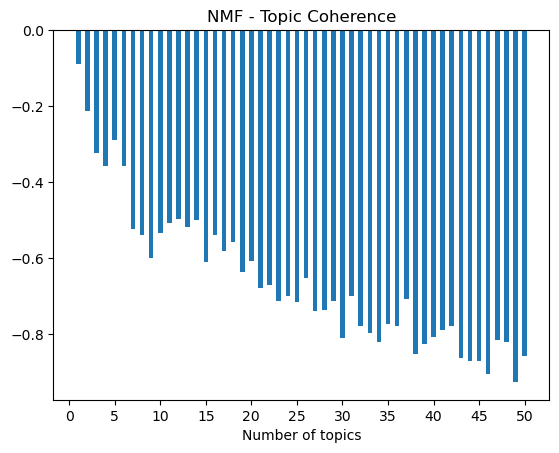

In [35]:
#looking at just topic coherence
fig, ax = plt.subplots()
plt.bar(range(1, 51), nmf_coherence_scores, width=0.5)
plt.xlabel('Number of topics')
ax.set_xticks(np.arange(0, 51, step=5))
plt.title('NMF - Topic Coherence')
plt.show()
#plt.savefig("plots/nmf_c.png")


In [36]:
def display_topics(model, feature_names, num_top_words,topic_names=None):
    """Given an NMF model, feature_names, and number of top words, print topic number 
    and its top feature names, up to specified number of top words.
    """
    
    # iterate through topics in topic-term matrix, 'H' aka
    # model.components_
    for ix, topic in enumerate(model.components_):        
        
        #print topic, topic number, and top words
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))


In [37]:
#view topic words where number of topics = 5
nmf_model = NMF(5)

# Learn an NMF model for given Document Term Matrix 'V' 
# Extract the document-topic matrix 'W'
doc_topic = nmf_model.fit_transform(data_dtm)

# Extract top words from the topic-term matrix 'H' 
display_topics(nmf_model, tfidf.get_feature_names(), 10)



Topic  0
love, time, good, place, life, feel, leave, thing, countess, room

Topic  1
supreme, witch, time, power, life, voodoo, magic, council, bitch, dissect

Topic  2
ruler, people, trump, divine, time, election, turd, men, vote, kill

Topic  3
god, moon, camera, land, blood, real, time, wait, people, truck

Topic  4
monsignor, time, nun, good, doctor, god, night, thought, story, church


### 2.4. CorEx <a class="anchor" id="2.4"></a>

In [38]:
import scipy.sparse as ss
import corextopic.corextopic as ct
import corextopic.vis_topic as vt
from sklearn.feature_extraction.text import CountVectorizer

#vectorize texts
vectorizer = CountVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False)    

#fit and transform text to a TF-IDF Doc-Term Matrix
doc_word = vectorizer.fit_transform(data_words)

doc_word = ss.csr_matrix(doc_word)

# Get words that label the columns (needed to extract readable topics and make anchoring easier)

words = list(np.asarray(vectorizer.get_feature_names()))


/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn(


In [39]:
corex_tc_scores = []

for i in range(1, 51):
    num_topics = i
    
    #build corex model
    topic_model = ct.Corex(n_hidden=num_topics, words=words, max_iter=10, verbose=False, seed=1) #set limit for max iter
    topic_model.fit(doc_word, words=words)
    
    #get tc scores
    tc = topic_model.tc 
    corex_tc_scores.append(tc)
    
    print('Number of topics:', num_topics, 'total correlation:', tc) #helps track progress

Number of topics: 1 total correlation: 61.28408519618351
Number of topics: 2 total correlation: 80.81623498721557
Number of topics: 3 total correlation: 96.22206552577184
Number of topics: 4 total correlation: 106.23438805857742
Number of topics: 5 total correlation: 118.77687748644101
Number of topics: 6 total correlation: 119.66037042644928
Number of topics: 7 total correlation: 124.41248741440643
Number of topics: 8 total correlation: 136.31268820683297
Number of topics: 9 total correlation: 137.3902861396548
Number of topics: 10 total correlation: 137.21330218395647
Number of topics: 11 total correlation: 140.84276365643362
Number of topics: 12 total correlation: 145.03403435224362
Number of topics: 13 total correlation: 149.01617573961605
Number of topics: 14 total correlation: 148.83865840919907
Number of topics: 15 total correlation: 156.22709539572992
Number of topics: 16 total correlation: 157.01492402885495
Number of topics: 17 total correlation: 157.76620642718888
Number of 

In [40]:
#looking at just total correlation
fig, ax = plt.subplots()
plt.bar(range(1, 51), corex_tc_scores, width=0.5)
plt.xlabel('Number of topics')
ax.set_xticks(np.arange(0, 51, step=5))
plt.title('CorEx - Total correlation')
plt.show()
#plt.savefig("plots/corex_tc.png")


/var/folders/4w/gm8h7rpj357763xbhgq_jznm0000gn/T/ipykernel_32929/414015934.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [41]:
#view topics for model with 5 topics
topic_model = ct.Corex(n_hidden=5, words=words, max_iter=10, verbose=False, seed=1)
topic_model.fit(doc_word, words=words)

topics = topic_model.get_topics()

for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))    


0: ignore, shocking, patience, check, wide, draw, filled, sealed, outrage, pick
1: champagne, gross, balance, reward, threat, marvelous, everlasting, celebrity, cake, deal
2: lead, cheating, sneak, sloppy, guide, checked, cute, hold, evil, responsibility
3: park, careful, beach, unfortunate, screen, training, interested, lesson, therapist, lawn
4: mortal, perfectly, cat, vulnerable, hand, long, leading, slipped, mask, switch


In [43]:
#view topics for model with 25 topics
topic_model = ct.Corex(n_hidden=25, words=words, max_iter=10, verbose=False, seed=1)
topic_model.fit(doc_word, words=words)

topics = topic_model.get_topics()

for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))    

#increasing teh number of topics doesn't really help

0: shooting, suppose, spent, television, prince, loaded, orange, impulse, corrupted, work
1: news, forward, star, version, announcement, eaten, pinhead, devoted, fireplace, harsh
2: recording, moment, thought, celebrity, delicate, boo, telling, location, task, radiant
3: challenge, attic, source, painted, received, supposed, disappearance, whew, wrath, struggle
4: woke, wearing, bell, episode, pig, extra, crawl, race, searching, fry
5: watched, door, artist, survival, plane, progress, extraordinary, point, personally, bare
6: effort, living, money, nope, crossed, prepared, minute, week, tortured, split
7: scream, wonderful, steel, triple, lab, scattered, homicide, space, service, bunch
8: idiot, level, neck, seek, contract, juice, virgin, finishing, exercise, interrupting
9: sing, ruined, path, milk, anxiety, cutting, party, breathe, pink, patience
10: election, begging, councilman, institution, voodoo, hard, political, birthday, pinky, tonight
11: soul, camp, tent, spend, carry, charg

In [42]:
plt.savefig("plots/lda_pvsc.png")
plt.savefig("plots/lda_c.png")
plt.savefig("plots/btm_pvsc.png")
plt.savefig("plots/btm_c.png")
plt.savefig("plots/nmf_c.png")
plt.savefig("plots/corex_tc.png")